# Backprop y entrenamiento para XOR

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

El objetivo es contruir por medio de una red neuronal con back propagation un ajuste a la función XOR, la cual tiene la siguiente forma y resultados:

In [2]:
def operacion_XOR(x1,x2):
    _and = x1+x2-1>0
    _or = x1+x2>0
    return int(_or-_and)

print(operacion_XOR(0,0),operacion_XOR(0,1),operacion_XOR(1,0),operacion_XOR(1,1))

0 1 1 0


Para estimarla probamos primero con la función de error MSE. Y definimos la siguiente clase:

In [3]:
class NeuralNetwork(object):
    def __init__(self, layers = [3, 2, 2, 1], activations=['relu', 'relu','linear'],mu= 0, sigma = 0.1,loos = 'MSE',seed = 0): # Definimos la forma que creemos nos ayudará
        assert(len(layers) == len(activations)+1)
        self.layers = layers
        self.activations = activations
        self.weights = []
        self.biases = []
        self.mu = mu
        self.sigma = sigma
        self.loos = loos
        self.seed = seed
        for i in range(len(layers)-1): # Iniciamos los pesos y sesgos de manera random según una distribución normal.
            np.random.seed(seed=self.seed+10*i)
            self.weights.append(np.random.normal(self.mu, self.sigma, (layers[i+1], layers[i])))
            #print('capa ', i, self.weights[-1])
            np.random.seed(seed=self.seed+10*i+1)
            self.biases.append(np.random.normal(self.mu, self.sigma, (layers[i+1], 1)))
            #print('capa ', i, self.biases[-1])
                
    @staticmethod
    def getActivationFunction(name): # Método que nos guarda las funciones de activación necesarias
        if(name == 'sigmoid'):
            return lambda x : 1/(1+np.exp(-x))
        elif(name == 'linear'):
            return lambda x : x
        elif(name == 'relu'):
            def relu(x):
                y = np.copy(x)
                y[y<0] = 0
                return y
            return relu
        else:
            print('Unknown activation function. linear is used')
            return lambda x: x
        
    @staticmethod
    def getDerivitiveActivationFunction(name): # Método que nos guarda las derivadas de las funciones de activación necesarias.
        if(name == 'sigmoid'):
            sig = lambda x : np.exp(x)/(1+np.exp(x))
            return lambda x :sig(x)*(1-sig(x)) 
        elif(name == 'linear'):
            return lambda x: 1
        elif(name == 'relu'):
            def relu_diff(x):
                y = np.copy(x)
                y[y>=0] = 1
                y[y<0] = 0
                return y
            return relu_diff
        else:
            print('Unknown activation function. linear is used')
            return lambda x: 1
        
    def error(self,y,y_hat,loos):
        if loos == 'MSE':
            return y-y_hat
        if loos == 'Cross-entropy':
            N = y_hat.shape[0]
            ce = -(y * np.log(y_hat))
            return ce
    
    def feedforward(self, x):
        a = np.copy(x)
        z_s = []
        a_s = [a]
        for i in range(len(self.weights)):
            #print('Vamos en la capa ', i)
            activation_function = self.getActivationFunction(self.activations[i])
            #print(self.weights[i],self.weights[i].shape)
            #print(a,a.shape)
            z_s.append(self.weights[i].dot(a) + self.biases[i]) 
            a = activation_function(z_s[-1])
            a_s.append(a)
        return (z_s, a_s)
    
    def backpropagation(self,y, z_s, a_s):
        dw = []  # dC/dw
        db = []  # dC/db
        deltas = [None] * len(self.weights)  # delta = dC/dZa
        deltas[-1] = ((self.error(y,a_s[-1],self.loos))*(self.getDerivitiveActivationFunction(self.activations[-1]))(z_s[-1])) # Delta L
        for i in reversed(range(len(deltas)-1)): # Calculamos los deltas para atrás
            deltas[i] = self.weights[i+1].T.dot(deltas[i+1])*(self.getDerivitiveActivationFunction(self.activations[i])(z_s[i]))        
        batch_size = y.shape[0] 
        db = [d.dot(np.ones((batch_size,1)))/float(batch_size) for d in deltas] # guardamos las derivadas respecto a los sesgos
        dw = [d.dot(a_s[i].T)/float(batch_size) for i,d in enumerate(deltas)] # guardamos las derivadas respecto a los pesos
        return dw, db          
    
    def train(self, x, y, epochs=100, lr = 0.01):
        for e in range(epochs): 
            z_s, a_s = self.feedforward(x)
            dw, db = self.backpropagation(y, z_s, a_s)
            self.weights = [w+lr*dweight for w,dweight in  zip(self.weights, dw)]
            self.biases = [w+lr*dbias for w,dbias in  zip(self.biases, db)]
            if (e+1)%np.floor(epochs/10) == 0:
                print("Epoch {} with loss = {}".format( e,np.linalg.norm(a_s[-1]-y)) )
        print("Final epoch with loss = {}".format(np.linalg.norm(a_s[-1]-y) )) 
                
    


Definimos los datasets a utilizar en el entrenamiento.

In [4]:
x1 = [0,1]
x2 = [0,1]
dataset_x = np.array([[a,b,1] for a in x1 for b in x2]).reshape(3, -1,order='F')
dataset_y_xor = np.zeros(len(x1)*len(x2))
for i in range(len(dataset_y_xor)):
    a = dataset_x[0][i]
    b = dataset_x[1][i]
    dataset_y_xor[i] = operacion_XOR(int(a),int(b))
dataset_x,dataset_y_xor

(array([[0, 1, 0, 1],
        [0, 0, 1, 1],
        [1, 1, 1, 1]]),
 array([0., 1., 1., 0.]))

In [5]:
nn1 = NeuralNetwork(loos = 'Cross-entropy')

nn1.train(dataset_x, dataset_y_xor, epochs=1000,  lr = 0.01)
_, a_s = nn1.feedforward(dataset_x)
pd.crosstab(a_s[-1][0], dataset_y_xor, rownames=['Predicción'], colnames=['Real'])

Epoch 99 with loss = 1.0250304951551408
Epoch 199 with loss = 1.1780702078582326
Epoch 299 with loss = 1.288886684152296
Epoch 399 with loss = 1.3506399778535556
Epoch 499 with loss = 1.383090856797395
Epoch 599 with loss = 1.399782681367233
Epoch 699 with loss = 1.4082884151879531
Epoch 799 with loss = 1.4126034725081036
Epoch 899 with loss = 1.414787666900157
Epoch 999 with loss = 1.4158918985250277
Final epoch with loss = 1.4158918985250277


Real,0.0,1.0
Predicción,,
0.988157,1,0
0.993860,0,1
1.004501,0,1
1.014032,1,0


In [6]:
nn2 = NeuralNetwork(loos = 'Cross-entropy')
nn2.train(dataset_x, dataset_y_xor, epochs=1000,  lr = 0.001)
_, a_s = nn2.feedforward(dataset_x)
pd.crosstab(a_s[-1][0], dataset_y_xor, rownames=['Predicción'], colnames=['Real'])

Epoch 99 with loss = 1.2216290084085133
Epoch 199 with loss = 1.1291946434809206
Epoch 299 with loss = 1.0709689070200255
Epoch 399 with loss = 1.0345169006172232
Epoch 499 with loss = 1.0133442436118925
Epoch 599 with loss = 1.0032682950154235
Epoch 699 with loss = 1.0013274938898755
Epoch 799 with loss = 1.0053318974984606
Epoch 899 with loss = 1.0136318415251055
Epoch 999 with loss = 1.024976330664368
Final epoch with loss = 1.024976330664368


Real,0.0,1.0
Predicción,,
0.603507,1,0
0.606066,0,1
0.611991,0,1
0.617153,1,0


In [7]:
nn3 = NeuralNetwork(loos = 'Cross-entropy',layers = [3, 20, 2, 1])
nn3.train(dataset_x, dataset_y_xor, epochs=1000,  lr = 0.001)
_, a_s = nn3.feedforward(dataset_x)
pd.crosstab(a_s[-1][0], dataset_y_xor, rownames=['Predicción'], colnames=['Real'])

Epoch 99 with loss = 1.2203458328883932
Epoch 199 with loss = 1.1275673246548066
Epoch 299 with loss = 1.0691903493849535
Epoch 399 with loss = 1.0327932982078916
Epoch 499 with loss = 1.0118674272174282
Epoch 599 with loss = 1.0022009201514614
Epoch 699 with loss = 1.0007962425529826
Epoch 799 with loss = 1.0054265818952057
Epoch 899 with loss = 1.0143779168732834
Epoch 999 with loss = 1.0263967123795141
Final epoch with loss = 1.0263967123795141


Real,0.0,1.0
Predicción,,
0.607203,1,0
0.613592,0,1
0.616169,0,1
0.623241,1,0


In [8]:
nn4 = NeuralNetwork(loos = 'MSE',layers = [3, 2, 2, 1])
nn4.train(dataset_x, dataset_y_xor, epochs=1000,  lr = 0.01)
_, a_s = nn4.feedforward(dataset_x)
pd.crosstab(a_s[-1][0], dataset_y_xor, rownames=['Predicción'], colnames=['Real'])

Epoch 99 with loss = 1.0537829311362683
Epoch 199 with loss = 1.0067497062691149
Epoch 299 with loss = 1.0015898287751315
Epoch 399 with loss = 1.000991628466303
Epoch 499 with loss = 1.000865689376823
Epoch 599 with loss = 1.000792257785856
Epoch 699 with loss = 1.000728503102706
Epoch 799 with loss = 1.0006696849527366
Epoch 899 with loss = 1.0006149339888217
Epoch 999 with loss = 1.0005638079135855
Final epoch with loss = 1.0005638079135855


Real,0.0,1.0
Predicción,,
0.495313,1,0
0.497224,0,1
0.501687,0,1
0.504670,1,0


In [9]:
nn5 = NeuralNetwork(loos = 'MSE',layers = [3, 20, 2, 1])
nn5.train(dataset_x, dataset_y_xor, epochs=1000,  lr = 0.001)
_, a_s = nn5.feedforward(dataset_x)
pd.crosstab(a_s[-1][0], dataset_y_xor, rownames=['Predicción'], colnames=['Real'])

Epoch 99 with loss = 1.326396755118701
Epoch 199 with loss = 1.2698179779011618
Epoch 299 with loss = 1.2220481171680164
Epoch 399 with loss = 1.1819711229857133
Epoch 499 with loss = 1.1485534524968608
Epoch 599 with loss = 1.1208493266444712
Epoch 699 with loss = 1.0980047850519035
Epoch 799 with loss = 1.0792593888061721
Epoch 899 with loss = 1.0639451379369784
Epoch 999 with loss = 1.051482743654066
Final epoch with loss = 1.051482743654066


Real,0.0,1.0
Predicción,,
0.334232,1,0
0.337584,0,1
0.338679,0,1
0.342825,1,0


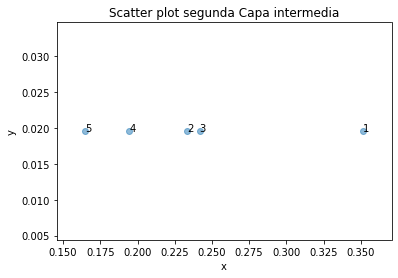

In [10]:

fig, ax = plt.subplots()

x = [nn1.weights[2][0][0],nn2.weights[2][0][0],nn3.weights[2][0][0],nn4.weights[2][0][0],nn5.weights[2][0][0]]
y = [nn1.weights[2][0][1],nn2.weights[2][0][1],nn3.weights[2][0][1],nn4.weights[2][0][1],nn5.weights[2][0][1]]
n = [1, 2, 3, 4, 5]
plt.scatter(x,y,alpha=0.5)
plt.title('Scatter plot segunda Capa intermedia')
plt.xlabel('x')
plt.ylabel('y')
for i, txt in enumerate(n):
    ax.annotate(txt, (x[i], y[i]))


plt.show()

# Conclusión
Vemos como la topología diseñada para crear una función XOR no genera resultados significativos ya que es una función que no es separable linealmente y los experimentos variando desde la cantidad de epochs y la función de error lo muestran.